In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of torchfusion.core.data.args.data_args failed: Traceback (most recent call last):
  File "/home/ataraxia/.virtualenvs/torchfusion/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/ataraxia/.virtualenvs/torchfusion/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/ataraxia/.virtualenvs/torchfusion/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/ataraxia/.virtualenvs/torchfusion/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
  File "/home/ataraxia/.virtualenvs/torchfusion/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/ataraxia/.virtualenvs/torchfusion/lib/python3.10

In [16]:
import os 
import sys 

os.environ['DATA_ROOT_DIR'] = '/home/ataraxia/Datasets/'
os.environ['TORCH_FUSION_CACHE_DIR'] = '/home/ataraxia/torchfusion/cache/'
os.environ['TORCH_FUSION_OUTPUT_DIR'] = '/home/ataraxia/torchfusion/output/torchfusion'

PATH_TO_SOURCE_DIR = os.path.abspath("../../../src/")
PATH_TO_CONFIGS_DIR = os.path.abspath("../../../cfg/")
sys.path.append(PATH_TO_SOURCE_DIR)

print("Adding source path: ", PATH_TO_SOURCE_DIR)
print("Using configs path: ", PATH_TO_CONFIGS_DIR)

Adding source path:  /home/ataraxia/Projects/torchfusionv2/src
Using configs path:  /home/ataraxia/Projects/torchfusionv2/cfg


In [17]:
from torchfusion.core.training.utilities.constants import TrainingStage
from hydra import compose, initialize, initialize_config_dir
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf
from hydra.core.hydra_config import HydraConfig
from torchfusion.core.args.args import FusionArguments
from torchfusion.utilities.dataclasses.dacite_wrapper import from_dict
from torchfusion.core.training.fusion_trainer import FusionTrainer

In [18]:
def initialize_hydra(config_path:str):
    # clear previous instances of hydra
    GlobalHydra.instance().clear() 

    # initialize hydra
    initialize_config_dir(version_base=None, config_dir=f"{PATH_TO_CONFIGS_DIR}/{config_path}")

    # compose a hydra config from the path given
    overrides = [
        "args/data_args=datasets/image_classification/tobacco3482", # prepare cifar10
    ]
    cfg = compose(config_name="prepare_datasets.yaml", overrides=overrides, return_hydra_config=True)
    hydra_config = cfg['hydra']
    hydra_config.runtime.output_dir = './'
    cfg = OmegaConf.to_object(cfg['args'])
    
    # # in case of notebooks we remove the analyzer arguments as the notebook itself runs the analysis code
    # args = from_dict(data_class=FusionArguments, data=cfg)   
    
    # # set tb logger to off
    # args.training_args.log_to_tb = False
    
    # # you can update args here
    # # for example set train_val_sampler to None
    # args.train_val_sampler = None
    
    # # print the default config that we received
    # print ("Using the following configuration: ")
    # print(args)
    
    return args, hydra_config
    
args, hydra_config = initialize_hydra("defaults")

MissingConfigException: In 'args/data_args/datasets/image_classification/tobacco3482': Could not find 'args/data_args/train_val_sampler/random_split'

Config search path:
	provider=hydra, path=pkg://hydra.conf
	provider=main, path=file:///home/ataraxia/Projects/torchfusionv2/cfg/defaults
	provider=schema, path=structured://

In [ ]:
from dataclasses import dataclass, field
from typing import Optional
import torch
import numpy as np
from torch.utils.data import Subset
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, RandomCrop, Resize
from torchfusion.core.constants import DataKeys
from torchfusion.core.data.data_augmentations.general import DictTransform
from torchfusion.core.data.utilities.containers import TransformsDict
from torchfusion.core.models.utilities.data_collators import BatchToTensorDataCollator
from torchfusion.utilities.logging import get_logger

def get_trainer(pretrained_checkpoint=None, transforms=None):
    trainer = FusionTrainer(args, hydra_config=hydra_config)

    # setup training
    trainer._setup_training(setup_tb_logger=False)

    # setup datamodule
    trainer._datamodule = trainer._setup_datamodule(stage=None, realtime_transforms=transforms)
        
    # setup dataloaders
    trainer._args.data_loader_args.per_device_train_batch_size = 32
    trainer._args.data_loader_args.per_device_eval_batch_size = 32
    trainer._args.data_loader_args.dataloader_num_workers = 1
    trainer._test_dataloader = trainer._datamodule.test_dataloader(
        trainer._args.data_loader_args.per_device_eval_batch_size,
        dataloader_num_workers=trainer._args.data_loader_args.dataloader_num_workers,
        pin_memory=trainer._args.data_loader_args.pin_memory,
    )
    
    return trainer

# create custom transforms. If not provided, transforms defined in the configuration file will be used
transforms = TransformsDict()
transforms.train = Compose([
    DictTransform(key=DataKeys.IMAGE, transform=[RandomHorizontalFlip(), RandomCrop(32, padding=4), ToTensor()]),
])
transforms.validation = Compose([
    DictTransform(key=DataKeys.IMAGE, transform=ToTensor()),
])
transforms.test = Compose([
    DictTransform(key=DataKeys.IMAGE, transform=ToTensor()),
])

trainer = get_trainer(transforms=None)

2024-04-17 19:34:44 ataraxia-B450-AORUS-ELITE torchfusion[29925] INFO Global seed set to 42
2024-04-17 19:34:44 ataraxia-B450-AORUS-ELITE torchfusion[29925] INFO Setting output directory: ./
2024-04-17 19:34:44 ataraxia-B450-AORUS-ELITE torchfusion[29925] INFO Setting up datamodule...
2024-04-17 19:34:44 ataraxia-B450-AORUS-ELITE torchfusion[29925] INFO Defining [train] realtime transforms:
2024-04-17 19:34:44 ataraxia-B450-AORUS-ELITE torchfusion[29925] INFO 0, ['image']: Compose(
    ToTensor()
    GrayScaleToRGB()
    Rescale(size=[224, 224], interpolation='bilinear', max_size=None, antialias=False)
    ConvertImageDtype()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
2024-04-17 19:34:44 ataraxia-B450-AORUS-ELITE torchfusion[29925] INFO Defining [validation] realtime transforms:
2024-04-17 19:34:44 ataraxia-B450-AORUS-ELITE torchfusion[29925] INFO 0, ['image']: Compose(
    ToTensor()
    GrayScaleToRGB()
    Rescale(size=[224, 224], interpolation='bilinear'

Files already downloaded and verified


2024-04-17 19:34:45 ataraxia-B450-AORUS-ELITE torchfusion[29925] WARNING Using train set as validation set as no validation dataset exists. If this behavior is not required set, do_val=False in config.
2024-04-17 19:34:45 ataraxia-B450-AORUS-ELITE torchfusion[29925] INFO Training set size = 50000
2024-04-17 19:34:45 ataraxia-B450-AORUS-ELITE torchfusion[29925] INFO Validation set size = 50000


Files already downloaded and verified


2024-04-17 19:34:45 ataraxia-B450-AORUS-ELITE torchfusion[29925] INFO Test set size = 10000
2024-04-17 19:34:45 ataraxia-B450-AORUS-ELITE torchfusion[29925] INFO Dataset loaded with following features: {'label': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']}
2024-04-17 19:34:45 ataraxia-B450-AORUS-ELITE torchfusion[29925] INFO Number of labels = 10
2024-04-17 19:34:45,607 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<torchfusion.data.da': 
	{'sampler': <torch.utils.data.sampler.SequentialSampler object at 0x7f04458cf8b0>, 'batch_size': 32, 'collate_fn': BatchToTensorDataCollator(allowed_keys=None, type_map=None), 'num_workers': 1, 'pin_memory': True, 'shuffle': False, 'drop_last': False}


2024-04-17 19:35:13 ataraxia-B450-AORUS-ELITE torchfusion[29925] INFO Batch information: 
2024-04-17 19:35:13 ataraxia-B450-AORUS-ELITE torchfusion[29925] INFO Batch element=image, shape=torch.Size([32, 3, 224, 224]), type=torch.float32
Example: tensor([[[ 0.5878,  0.5878,  0.5878,  ..., -0.1314, -0.1314, -0.1314],
         [ 0.5878,  0.5878,  0.5878,  ..., -0.1314, -0.1314, -0.1314],
         [ 0.5878,  0.5878,  0.5878,  ..., -0.1314, -0.1314, -0.1314],
         ...,
         [-1.1932, -1.1932, -1.1932,  ..., -1.7583, -1.7583, -1.7583],
         [-1.1932, -1.1932, -1.1932,  ..., -1.7583, -1.7583, -1.7583],
         [-1.1932, -1.1932, -1.1932,  ..., -1.7583, -1.7583, -1.7583]],

        [[-0.0749, -0.0749, -0.0749,  ..., -0.5476, -0.5476, -0.5476],
         [-0.0749, -0.0749, -0.0749,  ..., -0.5476, -0.5476, -0.5476],
         [-0.0749, -0.0749, -0.0749,  ..., -0.5476, -0.5476, -0.5476],
         ...,
         [-0.1625, -0.1625, -0.1625,  ..., -0.8627, -0.8627, -0.8627],
         [-0.1

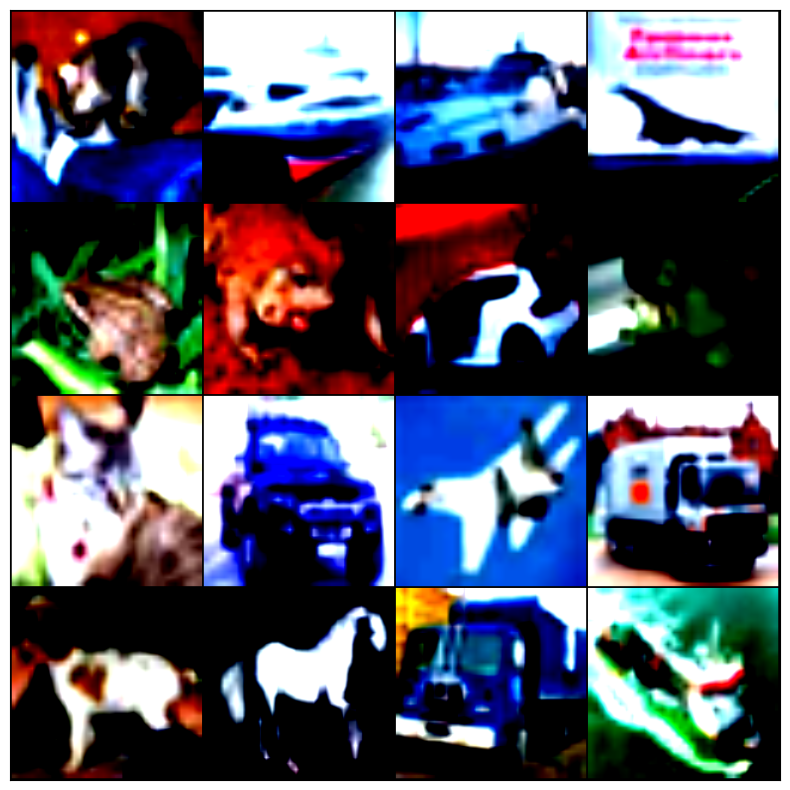

In [ ]:
# setup dataloaders
trainer._datamodule._collate_fns.test = BatchToTensorDataCollator(type_map={'image': torch.float32, 'label': torch.long})
with torch.no_grad():
    for batch in trainer._test_dataloader:
        image = batch['image']
        image = image.cuda()
        trainer._datamodule.show_batch(batch)
        break